# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [2]:
pd.set_option('display.max_columns', None)
# load Tables
all_features = pd.read_csv('data/all_features.csv', parse_dates = ['fl_date'])
flights_test = pd.read_csv('data/flights_test.csv', parse_dates = ['fl_date'])

In [3]:
all_features.isnull().sum()

fl_date                    0
mkt_unique_carrier         0
branded_code_share         0
mkt_carrier_fl_num         0
op_unique_carrier          0
op_carrier_fl_num          0
origin                     0
origin_city_name           0
dest                       0
dest_city_name             0
crs_dep_time               0
dep_time                   0
dep_delay                  0
taxi_out                   0
wheels_off                 0
wheels_on                  0
taxi_in                    0
crs_arr_time               0
arr_time                   0
arr_delay                  0
cancelled                  0
cancellation_code          0
diverted                   0
dup                        0
crs_elapsed_time           0
actual_elapsed_time        0
air_time                   0
distance                   0
carrier_delay              0
weather_delay              0
nas_delay                  0
security_delay             0
late_aircraft_delay        0
route_id                   0
month         

#### Missing fuel values
There are a number of nulls in the fuel data, and this is because the fuel data is not as up to date as the flights data. At least for the months of Oct-Dec 2019 (there may be more months) there is no fuel data.

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [4]:
all_features['day'] = all_features['fl_date'].dt.day
model_features = ['year', 'month', 'day', 'origin', 'dest', 'mkt_unique_carrier', 'route_id', 'distance', 'crs_elapsed_time']
model_features_df = all_features[model_features]
target = all_features['arr_delay']

In [5]:
categorical = ['year', 'month', 'day', 'origin', 'dest', 'route_id', 'mkt_unique_carrier']
numerical = ['distance', 'crs_elapsed_time']

scaler = StandardScaler()
scaler.fit(model_features_df[numerical])

def feature_engineer(df, categorical, numerical):
    df_encoded = pd.get_dummies(df, columns = categorical)
    df_engineered = scaler.transform(df_encoded[numerical])
    return df_engineered

model_features_engineered = feature_engineer(model_features_df, categorical, numerical)

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [6]:
model_features_df.head(2)

,year,month,day,origin,dest,mkt_unique_carrier,route_id,distance,crs_elapsed_time
0,2018,6,17,MSN,PHL,F9,MSN-PHL,764.0,127.0
1,2019,2,6,PIT,EWR,UA,PIT-EWR,319.0,90.0


/var/folders/k6/sjx5jh0s4ps0mm1lbstv_yrm0000gn/T/ipykernel_62206/3464097401.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = pd.concat([model_features_df, all_features['arr_delay']], axis = 1).corr()


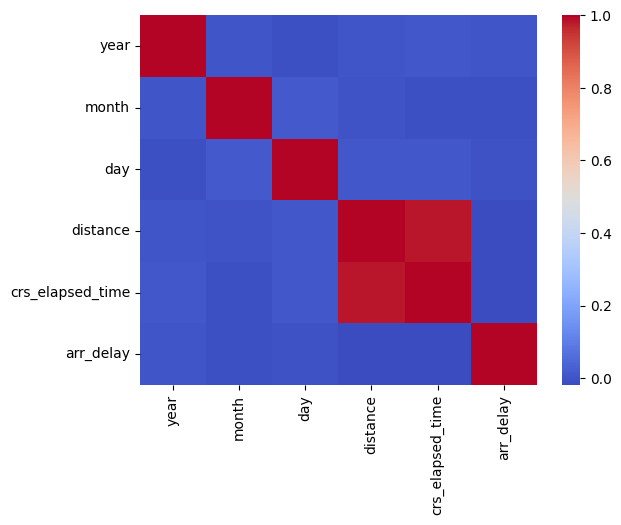

In [7]:
# Visualize correlation
corr = pd.concat([model_features_df, all_features['arr_delay']], axis = 1).corr()
corr
sns.heatmap(corr, cmap='coolwarm')
plt.show()

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [8]:
# initialize X & y variables, where y = target variable 'arr_delay'
X = model_features_engineered
y = target

### Linear Regression Model

In [9]:
# initialize linear regression model:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()

# fit model to training data
lr.fit(X_train, y_train)

# make predictions on test data
y_pred = lr.predict(X_test)

In [10]:
# evaluation of linear regression model with mse, mae, r2, and rmse:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error = {:.3f}.'.format(mse))

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error = {:.3f}.'.format(mae))

r2 = r2_score(y_test, y_pred)
print('R2_score = {:.3f}.'.format(r2))

rmse = np.sqrt(mse)
print('Root Mean Squared Error = {:.3f}.'.format(rmse))

Mean Squared Error = 2845.828.
Mean Absolute Error = 25.127.
R2_score = 0.000.
Root Mean Squared Error = 53.346.


R squared is negative indicating the model performs worse that the baseline and cannot exlpain the variability of the target variable. 

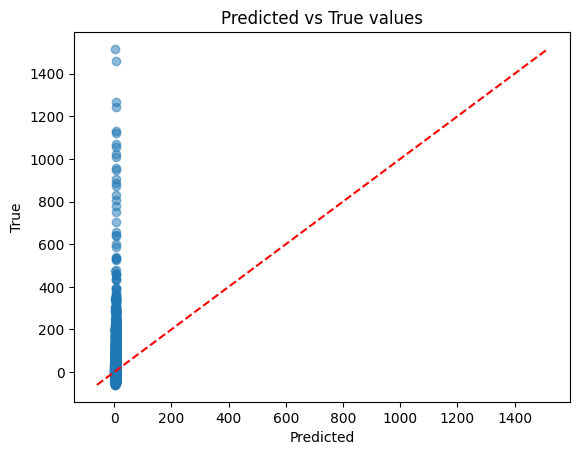

In [11]:
# Create a scatter plot of predicted vs true values
plt.scatter(y_pred, y_test, alpha=0.5)

# Add a diagonal line to represent where predicted = true
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Predicted vs True values')

# Show the plot
plt.show()

### Ridge Regression Model

In [12]:
# ridge regression uses a penalty term and reduces variance
# we will import Ridge cross validation to find the best alpha that wikk fir our model the best:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2, 2.5, 3, 3.5, 4.0])

# fit model to training data
ridge.fit(X_train, y_train)

# make prediction on test data
y_pred_ridge = ridge.predict(X_test)

In [13]:
# evaluation of ridge regression model with best alpha, mse, mae, r2, and rmse:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Alpha that best fits ridge model:', ridge.alpha_)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print('Mean Squared Error = {:.3f}.'.format(ridge_mse))

ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
print('Mean Absolute Error = {:.3f}.'.format(ridge_mae))

ridge_r2 = r2_score(y_test, y_pred_ridge)
print('R2_score = {:.3f}.'.format(ridge_r2))

ridge_rmse = np.sqrt(ridge_mse)
print('Root Mean Squared Error = {:.3f}.'.format(ridge_rmse))

Alpha that best fits ridge model: 4.0
Mean Squared Error = 2845.828.
Mean Absolute Error = 25.127.
R2_score = 0.000.
Root Mean Squared Error = 53.346.


marginally better results than linear regression model

### Decision Tree Classifier Model

In [14]:
# import decision tree regressor:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)

# fit model to training data
tree.fit(X_train, y_train) 

# make prediction on test data
y_pred_tree = tree.predict(X_test) 

In [15]:
# evaluation of decision tree model mse, mae, r2, and rmse:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

tree_mse = mean_squared_error(y_test, y_pred_tree)
print('Mean Squared Error = {:.3f}.'.format(tree_mse))

tree_mae = mean_absolute_error(y_test, y_pred_tree)
print('Mean Absolute Error = {:.3f}.'.format(tree_mae))

tree_r2 = r2_score(y_test, y_pred_tree)
print('R2_score = {:.3f}.'.format(tree_r2))

tree_rmse = np.sqrt(tree_mse)
print('Root Mean Squared Error = {:.3f}.'.format(tree_rmse))

Mean Squared Error = 3847.946.
Mean Absolute Error = 30.307.
R2_score = -0.352.
Root Mean Squared Error = 62.032.


this model performs worse than both linear and ridge regression models

### Random Forest Model

In [16]:
# import random forest regressor:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, random_state=42)  # using 100 estimators took too long please reduce for your machine

# fit model to training data
forest.fit(X_train, y_train)

# make prediction on test data
y_pred_forest = forest.predict(X_test)

In [17]:
# evaluation of forest model mse, mae, r2, and rmse:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

forest_mse = mean_squared_error(y_test, y_pred_forest)
print('Mean Squared Error = {:.3f}.'.format(forest_mse))

forest_mae = mean_absolute_error(y_test, y_pred_forest)
print('Mean Absolute Error = {:.3f}.'.format(forest_mae))

forest_r2 = r2_score(y_test, y_pred_forest)
print('R2_score = {:.3f}.'.format(forest_r2))

forest_rmse = np.sqrt(forest_mse)
print('Root Mean Squared Error = {:.3f}.'.format(forest_rmse))

Mean Squared Error = 3391.778.
Mean Absolute Error = 28.651.
R2_score = -0.191.
Root Mean Squared Error = 58.239.


the random forest model is better than the tree model but still does not outperform the ridge regresssion model. 
overall all the models are not doing a great job at prediciting the target variable

### XGBoost

In [19]:
# import XGBoost:
import xgboost as xgb

# convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# set hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror'
}

# train the model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# make prediction on test data
y_pred_xgboost = xgb_model.predict(dtest)

In [20]:
# evaluation of XGBoost model mse, mae, r2, and rmse:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgboost_mse = mean_squared_error(y_test, y_pred_xgboost)
print('Mean Squared Error = {:.3f}.'.format(xgboost_mse))

xgboost_mae = mean_absolute_error(y_test, y_pred_xgboost)
print('Mean Absolute Error = {:.3f}.'.format(xgboost_mae))

xgboost_r2 = r2_score(y_test, y_pred_xgboost)
print('R2_score = {:.3f}.'.format(xgboost_r2))

xgboost_rmse = np.sqrt(xgboost_mse)
print('Root Mean Squared Error = {:.3f}.'.format(xgboost_rmse))

Mean Squared Error = 2843.947.
Mean Absolute Error = 25.112.
R2_score = 0.001.
Root Mean Squared Error = 53.329.


the XGBoost model still does not provide us with a strong model based on the evaluation metrics to predict our target variable.  However, if we have to pick one it would have to be the Ridge Regression Model.

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [21]:
# create dataframe table for chosen model of ridge regression
y_pred_ridge = pd.DataFrame(y_pred_ridge)
y_pred_ridge.head()

,0
0,6.439467
1,5.911184
2,6.510055
3,6.958231
4,6.187362


In [22]:
# create column name that replaces '0' with 'Flight_Delays_Predictions'

In [23]:
y_pred_ridge = y_pred_ridge.rename(columns={0: 'flight_delays_predictions'})
y_pred_ridge.head()

,flight_delays_predictions
0,6.439467
1,5.911184
2,6.510055
3,6.958231
4,6.187362


In [25]:
# join y_pred_ridge dataframe into flights_test

# Reset the index of y_pred_ridge so that it matches the index of train_flights_df
y_pred_ridge.reset_index(drop=True, inplace=True)

# from main datafram select columns needed for sample_submission
submission_columns = flights_test[['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin', 'dest']]

# Concatenate the dataframes
submission = pd.concat([submission_columns, y_pred_ridge], axis=1)

# View the merged dataframe
submission.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,flight_delays_predictions
0,2020-01-01,WN,5888,ONT,SFO,6.439467
1,2020-01-01,WN,6276,ONT,SFO,5.911184
2,2020-01-01,WN,4598,ONT,SJC,6.510055
3,2020-01-01,WN,4761,ONT,SJC,6.958231
4,2020-01-01,WN,5162,ONT,SJC,6.187362


In [28]:
# filter the DataFrame to show only the first 7 days of January 2020
submission_final = submission.query("fl_date >= '2020-01-01' and fl_date < '2020-01-08'")

In [30]:
submission_final

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,flight_delays_predictions
0,2020-01-01,WN,5888,ONT,SFO,6.439467
1,2020-01-01,WN,6276,ONT,SFO,5.911184
2,2020-01-01,WN,4598,ONT,SJC,6.510055
3,2020-01-01,WN,4761,ONT,SJC,6.958231
4,2020-01-01,WN,5162,ONT,SJC,6.187362
...,...,...,...,...,...,...
150618,2020-01-07,DL,4813,DTW,JFK,NaN
150619,2020-01-07,DL,4814,GSP,LGA,NaN
150620,2020-01-07,DL,4815,ATL,XNA,NaN
150621,2020-01-07,DL,4815,XNA,ATL,NaN


In [33]:
# save above dataframe as csv into main project folder

import os

file_path = os.path.join(os.getcwd(), 'submission_final.csv')
submission_final.to_csv(file_path, index=False)

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.